# ELO Merchant Recognition (Final Model)

## 0. Import all modules

In [1]:
#Import all modules

#data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import random
import datetime

#visulalization
%matplotlib inline
import matplotlib.pyplot as plt
#from IPython.display import image

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import partial_dependence
from sklearn.preprocessing import LabelEncoder

#import xgboost as xgb
#from xgboost import XGBClassifier
#from catboost import Pool, CatBoostClassifier
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
#from pygam import LogisticGAM

#cross-validation
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.stats as stats

#parallel processing
from joblib import Parallel, delayed
import multiprocessing
cpus=multiprocessing.cpu_count()

#Import the garbage collection module
import gc   #gc.collect -> Manual garbage collection
import time

#Set maximum number of rows,columns to be shown. Maximum column width made to 500.
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 500)

In [2]:
import os
os.chdir("C:\Master\PD_Career\Courses\Springboard\ELO Merchant Category Recommendation")

#data directory
data_path = "datasets/"
intermediate_data_path = "datasets/intermediate/"
submit_data_path = "datasets/submit/"

# Common Functions used across datasets

In [11]:
def one_hot_encoding(df,col):
    one_hot=pd.get_dummies(df[col])
    one_hot.columns=[col+'_'+ str(element) for element in one_hot.columns.values ]
    df = df.join(one_hot)
    df = df.drop(col,axis=1)
    return df

In [12]:
def transform_train_test(dataset):
    dataset['elapsed_active_days'] = (datetime.date(2018, 2, 1) - dataset['first_active_month'].dt.date).dt.days
    return dataset

In [13]:
def transform_train_hist_tran(dataset):
    # Convert the binary variables to 0, 1 format
    dataset['authorized_flag']=dataset['authorized_flag'].map({'Y':1,'N':0})
    dataset['category_1']=dataset['category_1'].map({'Y':1,'N':0})
    dataset['purchase_elapsed_time'] = (datetime.date(2018, 2, 1) - dataset['purchase_date'].dt.date).dt.days
    dataset['category_2'].fillna(dataset['category_2'].median(),inplace=True)
    dataset['category_2']=dataset['category_2'].astype(int)
    dataset=one_hot_encoding(dataset,'category_2')
    dataset.drop('category_2_5',axis=1,inplace=True)
    
    # Replace the null in category_3 with the value 'A'. 
    dataset['category_3'].fillna('A',inplace=True)
    dataset=one_hot_encoding(dataset,'category_3')
    dataset.drop('category_3_C',axis=1,inplace=True)

    display(dataset.head())
    display(dataset.isna().sum())
    return dataset

In [14]:
def aggregate_history(history):
    
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1_x': ['sum', 'mean'],
        'category_2_1_x': ['sum','mean'],
        'category_2_2_x': ['sum','mean'],
        'category_2_3_x': ['sum','mean'],
        'category_2_4_x': ['sum','mean'],        
        'category_3_A': ['sum'],
        'category_3_B': ['sum'],
        'city_id_x': ['nunique'],
        'city_id_69':['sum'],
        'city_id_neg_1':['sum'],
        'city_id_333':['sum'],
        'installments': [np.ptp,'sum', 'max', 'min'],
        'merchant_category_id_x': ['nunique'],
        'merchant_group_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': [np.ptp, 'sum', 'min', 'max'],
        'purchase_amount': [np.ptp, 'sum', 'max', 'min'],
        'state_id_x': ['nunique'],
        'subsector_id_x': ['nunique'],
        'purchase_elapsed_time':[np.ptp,'sum', 'median', 'max', 'min'],
        'numerical_1': [np.ptp, 'sum','max','min'],
        'avg_sales_lag3': ['sum','mean'],
        'avg_sales_lag6': ['sum','mean'],
        'avg_sales_lag12': ['sum','mean'],
        'avg_purchases_lag3': ['sum','mean'],
        'avg_purchases_lag6': ['sum','mean'],  
        'avg_purchases_lag12': ['sum','mean'],
        'category_4':['sum'],
        'numerical_1_low':['sum']
        }
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['hist_' + '_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id').size().reset_index(name='hist_transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [15]:
def aggregate_new_merchant(new_merchants_dataset):
    
    new_merchants_dataset.loc[:, 'purchase_date'] = pd.DatetimeIndex(new_merchants_dataset['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1_x': ['sum', 'mean'],
        'category_2_1_x': ['sum','mean'],
        'category_2_2_x': ['sum','mean'],
        'category_2_3_x': ['sum','mean'],
        'category_2_4_x': ['sum','mean'],        
        'category_3_A': ['sum'],
        'category_3_B': ['sum'],
        'city_id_x': ['nunique'],
        'city_id_69':['sum'],
        'city_id_neg_1':['sum'],
        'city_id_333':['sum'],
        'installments': [np.ptp,'sum', 'max', 'min'],
        'merchant_category_id_x': ['nunique'],
        'merchant_group_id': ['nunique'],
        'merchant_id': ['nunique'],
        'month_lag': [np.ptp, 'sum', 'min', 'max'],
        'purchase_amount': [np.ptp, 'sum', 'max', 'min'],
        'state_id_x': ['nunique'],
        'subsector_id_x': ['nunique'],
        'purchase_elapsed_time':[np.ptp,'sum', 'median', 'max', 'min'],
        'numerical_1': [np.ptp, 'sum','max','min'],
        'avg_sales_lag3': ['sum','mean'],
        'avg_sales_lag6': ['sum','mean'],
        'avg_sales_lag12': ['sum','mean'],
        'avg_purchases_lag3': ['sum','mean'],
        'avg_purchases_lag6': ['sum','mean'],  
        'avg_purchases_lag12': ['sum','mean'],
        'category_4':['sum'],
        'numerical_1_low':['sum']
        }
    agg_new_merchants_dataset = new_merchants_dataset.groupby(['card_id']).agg(agg_func)
    agg_new_merchants_dataset.columns = ['new_mer_' + '_'.join(col).strip() for col in agg_new_merchants_dataset.columns.values]
    agg_new_merchants_dataset.reset_index(inplace=True)
    
    df = (new_merchants_dataset.groupby('card_id').size().reset_index(name='new_mer_transactions_count'))
    
    agg_new_merchants_dataset = pd.merge(df, agg_new_merchants_dataset, on='card_id', how='left')
    
    return agg_new_merchants_dataset

## 1. Data Import, Cleaning and Wrangling

In [53]:
#Import train data
train=pd.read_csv(data_path+"train.csv",parse_dates=['first_active_month'])
print(train.shape)
display(train.info())

train = transform_train_test(train)

# We remove the outliers (target <-30) from training dataset as they may bring high skewness to the data
# train = train[train['target']>=-30]

display(train.head(10))

(201917, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
first_active_month    201917 non-null datetime64[ns]
card_id               201917 non-null object
feature_1             201917 non-null int64
feature_2             201917 non-null int64
feature_3             201917 non-null int64
target                201917 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 9.2+ MB


None

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,92
5,2016-09-01,C_ID_0894217f2f,4,2,0,0.871585,518
6,2016-12-01,C_ID_7e63323c00,3,2,1,0.230129,427
7,2017-09-01,C_ID_dfa21fc124,3,2,1,2.135850,153
8,2017-08-01,C_ID_fe0fdac8ea,2,1,0,-0.065406,184
9,2016-08-01,C_ID_bf62c0b49d,2,2,0,0.300062,549


In [6]:
# The training outliers dataset
train_outliers = train[train['target']<-30]



In [6]:
# Because of sheer volume of transactions data, we will add another variable to the training dataset that divides 
# target into low, medium and high category.

# This code needs to run only once to prepare the intermediate datasets

# target_low_lower_limit=np.percentile(train['target'],0)
# target_low_upper_limit=np.percentile(train['target'],33.3)
# target_med_upper_limit=np.percentile(train['target'],66.6)
# display((target_low_lower_limit, target_low_upper_limit,target_med_upper_limit))

# def target_range (row,low,high):
#     if row['target'] >= low and row['target'] < high:
#         return 1
#     else:
#         return 0


# train['target_low'] = 0
# train['target_med'] = 0

# train['target_low']= train.apply(lambda row: target_range(row,target_low_lower_limit,target_low_upper_limit),axis=1)
# train['target_med']= train.apply(lambda row: target_range(row,target_low_upper_limit,target_med_upper_limit),axis=1)

# display(sum(train['target_low']))
# display(sum(train['target_med']))

(-17.60814651, -0.5096408724, 0.45557336553999994)

66504

66503

In [7]:
# Divide the training dataset into 3 parts
# train_low_target=train[train['target_low']==1]
# train_med_target=train[train['target_med']==1]
# train_high_target=train[(train['target_low']==0) & (train['target_med']==0)]

In [8]:
# Saving the intermediate training datasets

# train_low_target.to_csv(intermediate_data_path+'train_low_target.csv',index=False)
# train_med_target.to_csv(intermediate_data_path+'train_med_target.csv',index=False)
# train_high_target.to_csv(intermediate_data_path+'train_high_target.csv',index=False)

In [20]:
# Delete the train dataset
del train
gc.collect()

In [74]:
# Functions for Data wrangling of Merchants dataset

# Used for city_id field
def city_derivation (row,col, value):
    if row[col] == value:
        return 1
    else:
        return 0

# Used for numerical_1 field
def numerical_range (row,value):
    if row['numerical_1'] <= value:
        return 1
    else:
        return 0

In [75]:
# Functions for Data wrangling of Merchants dataset

def transform_merchants(dataset):
    dataset=dataset.dropna(subset=['avg_sales_lag3','avg_sales_lag6', 'avg_sales_lag12'])
    # Apply one hot encoding and drop the original columns and column related to one element.
    dataset=one_hot_encoding(dataset,'most_recent_sales_range')
    dataset=one_hot_encoding(dataset,'most_recent_purchases_range')
    dataset.drop(['most_recent_sales_range_E','most_recent_purchases_range_E'],axis=1,inplace=True)
    # Dropping numerical_2 column as it is highly correlated to numerical_1.  
    dataset.drop('numerical_2',axis=1,inplace=True)

    # Transform the category fields appropriately.
    dataset['category_1'] = dataset['category_1'].map({'Y':1, 'N':0})
    dataset['category_4'] = dataset['category_4'].map({'Y':1, 'N':0})
    
    # Replacing the field category_2 by median. Then One Hot Encoding
    dataset['category_2'].fillna(dataset['category_2'].median(),inplace=True)
    dataset['category_2']=dataset['category_2'].astype(int)
    dataset=one_hot_encoding(dataset,'category_2')
    dataset.drop('category_2_5',axis=1,inplace=True)
    
    # As the numerical_1 column has value -0.057470 for more than 50% of records, An indicator was added.
    dataset['numerical_1_low']=dataset.apply(lambda row: numerical_range(row,-0.057470),axis=1)
    
    # Transform the city_id variable and create separate indicators for few cities 
    # with high transactions and purchase amounts
    dataset['city_id_69']=0
    dataset['city_id_neg_1']=0
    dataset['city_id_333']=0

    dataset['city_id_69']=dataset.apply(lambda row: city_derivation(row,'city_id',69),axis=1)
    dataset['city_id_neg_1']=dataset.apply(lambda row: city_derivation(row,'city_id',-1),axis=1)
    dataset['city_id_333']=dataset.apply(lambda row: city_derivation(row,'city_id',333),axis=1)
    
    #display(dataset.city_id_neg_1.value_counts(dropna=False))
    #display(dataset.city_id_69.value_counts(dropna=False))
    #display(dataset.city_id_333.value_counts(dropna=False))
    display(dataset.head(5))
    
    return dataset


In [76]:
# Import the Merchants Dataset and create features
merchants=pd.read_csv(data_path+"merchants.csv")
print(merchants.shape)
display(merchants.head(5))
#display(merchants.info())
display(merchants.isna().sum())

(334696, 22)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [77]:
merchants = transform_merchants(merchants)
# Save the intermediate merchants dataset
merchants.to_csv(intermediate_data_path+'merchants_transformed_1.csv',index=False)

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,category_1,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,most_recent_sales_range_A,most_recent_sales_range_B,most_recent_sales_range_C,most_recent_sales_range_D,most_recent_purchases_range_A,most_recent_purchases_range_B,most_recent_purchases_range_C,most_recent_purchases_range_D,category_2_1,category_2_2,category_2_3,category_2_4,numerical_1_low,city_id_69,city_id_neg_1,city_id_333
0,M_ID_838061e48c,8353,792,9,-0.057471,0,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,0,242,9,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
1,M_ID_9339d880ad,3184,840,20,-0.057471,0,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,0,22,16,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,M_ID_e726bbae1e,447,690,1,-0.057471,0,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,0,-1,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
16,M_ID_c929bb59af,9514,2,20,-0.057471,0,69667.00,1.000000,3,69667.00,1.000000,3,69667.00,1.000000,3,0,-1,20,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
17,M_ID_dd3ae3de10,30534,278,37,-0.057471,0,5180.00,4.000000,3,9830.00,4.166667,6,15826.00,5.600000,10,1,11,23,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


In [7]:
#Import historical transactions
historical_transactions=pd.read_csv(data_path+'historical_transactions.csv',parse_dates=['purchase_date'])
print(historical_transactions.shape)
display(historical_transactions.head(5)) #Preview historical_trasactions data
display(historical_transactions.info())
#display(historical_transactions.describe())

(29112361, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         object
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(5)
memory usage: 3.0+ GB


None

## Split of Historical Transactions into 3 parts based on card id target score. 
The below cell joins the historical transactions to training dataset and divides the dataset into 3 parts. <br>
This code needs to run only once. <br>

In [23]:
# # Divide the historical transactions into 3 parts based on target score (joined by card_id)
# hist_tran_low_target=pd.merge(train_low_target,historical_transactions, on='card_id', how='left')
# # display(hist_tran_low_target.head())
# hist_tran_low_target.to_csv(intermediate_data_path+'hist_tran_low_target.csv',index=False)
# del hist_tran_low_target
# gc.collect()
# hist_tran_med_target=pd.merge(train_med_target,historical_transactions, on='card_id', how='left')
# hist_tran_med_target.to_csv(intermediate_data_path+'hist_tran_med_target.csv',index=False)
# del hist_tran_med_target
# gc.collect()
# hist_tran_high_target=pd.merge(train_high_target,historical_transactions, on='card_id', how='left')
# hist_tran_high_target.to_csv(intermediate_data_path+'hist_tran_high_target.csv',index=False)
# del hist_tran_high_target
# gc.collect()
# del historical_transactions
# gc.collect()

In [33]:
# train_low_target_tran.to_csv(data_path+'train_low_target_tran.csv',index=False)
# del train_low_target_tran



27

In [64]:
#Import historical transactions
hist_tran_low_target=pd.read_csv(intermediate_data_path+'hist_tran_low_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_low_target.shape)
display(hist_tran_low_target.head(5)) #Preview historical_trasactions data
display(hist_tran_low_target.info())
#display(historical_transactions.describe())

(5775138, 22)


,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,Y,69,N,0,A,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,1.0,9,34
1,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,Y,69,N,0,A,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00,1.0,9,37
2,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,Y,69,N,0,A,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16,1.0,9,34
3,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,Y,69,N,0,A,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58,1.0,9,21
4,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,Y,69,N,0,A,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18,1.0,9,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5775138 entries, 0 to 5775137
Data columns (total 22 columns):
first_active_month      datetime64[ns]
card_id                 object
feature_1               int64
feature_2               int64
feature_3               int64
target                  float64
elapsed_active_days     int64
target_low              int64
target_med              int64
authorized_flag         object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](2), float64(3), int64(12), object(5)
memory usage: 969.3+ MB


None

In [69]:
# Transform the train and historical transactions dataset
hist_tran_low_target_2=transform_train_hist_tran(hist_tran_low_target)
hist_tran_low_target_2.head()
display(hist_tran_low_target_2.isna().sum())

first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
target_low                   0
target_med                   0
authorized_flag              0
city_id                      0
category_1                   0
installments                 0
merchant_category_id         0
merchant_id              26725
month_lag                    0
purchase_amount              0
purchase_date                0
state_id                     0
subsector_id                 0
purchase_elapsed_time        0
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

Join the training and historical transaction dataset with merchants dataset.

In [73]:
hist_tran_low_target_merchants=pd.merge(hist_tran_low_target_2,merchants, on='merchant_id', how='left')
display(hist_tran_low_target_merchants.head())
display(hist_tran_low_target_merchants.isna().sum())

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,target_low,target_med,authorized_flag,city_id_x,category_1_x,installments,merchant_category_id_x,merchant_id,month_lag,purchase_amount,purchase_date,state_id_x,subsector_id_x,purchase_elapsed_time,category_2_1_x,category_2_2_x,category_2_3_x,category_2_4_x,category_3_A,category_3_B,merchant_group_id,merchant_category_id_y,subsector_id_y,numerical_1,category_1_y,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id_y,state_id_y,most_recent_sales_range_A,most_recent_sales_range_B,most_recent_sales_range_C,most_recent_sales_range_D,most_recent_purchases_range_A,most_recent_purchases_range_B,most_recent_purchases_range_C,most_recent_purchases_range_D,category_2_1_y,category_2_2_y,category_2_3_y,category_2_4_y,numerical_1_low,city_id_69,city_id_neg_1,city_id_333
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,1,69,0,0,195,M_ID_cc72dac895,-3,-0.506033,2017-11-25 16:37:11,9,34,68,1,0,0,0,1,0,35.0,195.0,34.0,17.154803,0.0,1.07,1.085076,3.0,1.13,1.091386,6.0,1.16,1.126131,12.0,1.0,69.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,1,69,0,0,278,M_ID_c9c0f1cb3f,-7,-0.722114,2017-07-16 12:21:00,9,37,200,1,0,0,0,1,0,72004.0,560.0,34.0,-0.007896,0.0,1.20,1.197449,3.0,1.13,1.159456,6.0,1.12,1.213672,12.0,1.0,69.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,1,69,0,0,683,M_ID_36f9e41993,-6,-0.726171,2017-08-10 21:01:16,9,34,175,1,0,0,0,1,0,9215.0,683.0,34.0,0.150742,0.0,1.02,1.006072,3.0,1.08,1.010842,6.0,1.26,1.061942,12.0,1.0,69.0,9.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,1,69,0,0,309,M_ID_b790230ee9,-2,-0.610167,2017-12-15 12:06:58,9,21,48,1,0,0,0,1,0,93721.0,222.0,21.0,-0.047556,0.0,1.09,0.998382,3.0,0.90,0.874595,6.0,0.87,0.834836,12.0,1.0,69.0,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1,0,1,69,0,0,278,M_ID_ab67f6c982,-7,-0.307232,2017-07-08 15:13:18,9,37,208,1,0,0,0,1,0,4949.0,80.0,37.0,-0.027726,0.0,0.92,0.927273,3.0,0.93,0.937879,6.0,0.88,0.880952,12.0,1.0,69.0,9.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


first_active_month                   0
card_id                              0
feature_1                            0
feature_2                            0
feature_3                            0
target                               0
elapsed_active_days                  0
target_low                           0
target_med                           0
authorized_flag                      0
city_id_x                            0
category_1_x                         0
installments                         0
merchant_category_id_x               0
merchant_id                      26725
month_lag                            0
purchase_amount                      0
purchase_date                        0
state_id_x                           0
subsector_id_x                       0
purchase_elapsed_time                0
category_2_1_x                       0
category_2_2_x                       0
category_2_3_x                       0
category_2_4_x                       0
category_3_A             

In [75]:
agg_history_low_target = aggregate_history(hist_tran_low_target_merchants)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [76]:
agg_history_low_target.to_csv(intermediate_data_path+'agg_history_low_target.csv',index=False)
del agg_history_low_target
del train_low_target_tran_merchants
gc.collect()

In [ ]:
# If merchants transformed dataset is not loaded

# merchants=pd.read_csv(intermediate_data_path+"merchants_transformed.csv")
# print(merchants.shape)
# display(merchants.head(5))
# display(merchants.info())
# #display(merchants.describe())
# display(merchants.isna().sum())

## Next, We aggregate the medium dataset

In [21]:
#Import historical transactions
hist_tran_med_target=pd.read_csv(intermediate_data_path+'hist_tran_med_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_med_target.shape)
display(hist_tran_med_target.head(5)) #Preview historical_trasactions data
#display(hist_tran_med_target.info())
display(hist_tran_med_target.isna().sum())
#display(historical_transactions.describe())

(7020093, 22)


,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,0,1,Y,69,N,3,C,68,M_ID_879f625c89,-4,-0.596793,2017-09-04 16:50:16,1.0,9,27
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,0,1,Y,69,N,1,B,528,M_ID_124bc5f024,-12,-0.694315,2017-01-22 16:46:20,1.0,9,25
2,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,0,1,Y,69,N,5,C,68,M_ID_ac1b9b1c8d,-11,-0.348705,2017-02-03 20:07:16,1.0,9,27
3,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,0,1,Y,69,N,1,B,80,M_ID_8d027b0e80,-12,-0.662759,2017-01-12 20:59:31,1.0,9,37
4,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,396,0,1,Y,138,N,1,B,278,M_ID_ee47bd98e5,-3,-0.623044,2017-10-22 23:33:57,1.0,15,37


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7020093 entries, 0 to 7020092
Data columns (total 22 columns):
first_active_month      datetime64[ns]
card_id                 object
feature_1               int64
feature_2               int64
feature_3               int64
target                  float64
elapsed_active_days     int64
target_low              int64
target_med              int64
authorized_flag         object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](2), float64(3), int64(12), object(5)
memory usage: 1.2+ GB


None

first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
target_low                   0
target_med                   0
authorized_flag              0
city_id                      0
category_1                   0
installments                 0
category_3               43579
merchant_category_id         0
merchant_id              35634
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              601080
state_id                     0
subsector_id                 0
dtype: int64

In [24]:
hist_tran_med_target_2=transform_train_hist_tran(hist_tran_med_target)
hist_tran_med_target_2.head()
display(hist_tran_med_target_2.isna().sum())

first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
target_low                   0
target_med                   0
authorized_flag              0
city_id                      0
category_1                   0
installments                 0
merchant_category_id         0
merchant_id              35634
month_lag                    0
purchase_amount              0
purchase_date                0
state_id                     0
subsector_id                 0
purchase_elapsed_time        0
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

In [26]:
hist_tran_med_target_merchants=pd.merge(hist_tran_med_target_2,merchants, on='merchant_id', how='left')

In [27]:
agg_history_med_target = aggregate_history(hist_tran_med_target_merchants)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [28]:
agg_history_med_target.to_csv(intermediate_data_path+'agg_history_med_target.csv',index=False)
del agg_history_med_target
del hist_tran_med_target
del hist_tran_med_target_2
del hist_tran_med_target_merchants
gc.collect()

199

## Next, We aggregate the high target dataset 

In [29]:
#Import historical transactions
hist_tran_high_target=pd.read_csv(intermediate_data_path+'hist_tran_high_target.csv',parse_dates=['first_active_month', 'purchase_date'])
print(hist_tran_high_target.shape)
display(hist_tran_high_target.head(5)) #Preview historical_trasactions data
# display(hist_tran_high_target.info())
display(hist_tran_high_target.isna().sum())
#display(historical_transactions.describe())

(5054673, 22)


,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,target_low,target_med,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-6,-0.682504,2017-08-26 21:01:42,5.0,5,33
1,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-12,-0.637515,2017-02-23 19:32:42,5.0,5,33
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-9,-0.715457,2017-05-25 21:12:29,5.0,5,33
3,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,0,0,Y,143,N,0,A,705,M_ID_5634fd83e0,-7,-0.712482,2017-07-21 16:28:16,5.0,5,33
4,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,549,0,0,Y,143,N,0,A,705,M_ID_17511eed62,-11,-0.714676,2017-03-08 15:47:51,5.0,5,33


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5054673 entries, 0 to 5054672
Data columns (total 22 columns):
first_active_month      datetime64[ns]
card_id                 object
feature_1               int64
feature_2               int64
feature_3               int64
target                  float64
elapsed_active_days     int64
target_low              int64
target_med              int64
authorized_flag         object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           datetime64[ns]
category_2              float64
state_id                int64
subsector_id            int64
dtypes: datetime64[ns](2), float64(3), int64(12), object(5)
memory usage: 848.4+ MB


None

first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
target_low                   0
target_med                   0
authorized_flag              0
city_id                      0
category_1                   0
installments                 0
category_3               34587
merchant_category_id         0
merchant_id              23459
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              495214
state_id                     0
subsector_id                 0
dtype: int64

In [32]:
hist_tran_high_target_2=transform_train_hist_tran(hist_tran_high_target)

first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
target_low                   0
target_med                   0
authorized_flag              0
city_id                      0
category_1                   0
installments                 0
merchant_category_id         0
merchant_id              23459
month_lag                    0
purchase_amount              0
purchase_date                0
state_id                     0
subsector_id                 0
purchase_elapsed_time        0
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

In [34]:
hist_tran_high_target_merchants=pd.merge(hist_tran_high_target_2,merchants, on='merchant_id', how='left')

In [35]:
agg_history_high_target = aggregate_history(hist_tran_high_target_merchants)

In [36]:
# Saving the intermediate files.
agg_history_high_target.to_csv(intermediate_data_path+'agg_history_high_target.csv',index=False)

# del agg_history_high_target
del hist_tran_high_target
del hist_tran_high_target_2
del hist_tran_high_target_merchants
gc.collect()

118

## Join all aggrgated historical transactions dataset and add aggregates from new merchant transactions.

In [41]:
# Load aggregated transaction files for low and medium target transactions.
agg_history_low_target=pd.read_csv(intermediate_data_path+"agg_history_low_target.csv")
#display(agg_history_low_target.shape)
#display(agg_history_low_target.head(5))
#display(agg_history_low_target.isna().sum())

agg_history_med_target=pd.read_csv(intermediate_data_path+"agg_history_med_target.csv")
#display(agg_history_med_target.shape)
#display(agg_history_med_target.head(5))
#display(agg_history_med_target.isna().sum())

agg_history=pd.concat([agg_history_low_target, agg_history_med_target, agg_history_high_target])

display(agg_history.head())
display(agg_history.shape)
display(agg_history.isna().sum())

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_00042d509c,73,20,0.273973,41,0.561644,63.0,0.863014,0.0,0.000000,10.0,0.136986,0.0,0.0,2.0,53.0,4,0.0,63.0,0.0,5,94,4,-1,10,8,11,5,-83,-5,0,1.050609,-45.114923,0.310177,-0.740431,3,9,153,5991,70.0,191,38,12.334141,11.688319,12.276670,-0.057471,135.04,1.849863,146.44,2.006027,141.25,1.934932,198.571663,2.720160,227.676786,3.118860,223.774187,3.065400,72.0,48.0
1,C_ID_0004c2a5ab,78,75,0.961538,31,0.397436,77.0,0.987179,0.0,0.000000,0.0,0.000000,0.0,0.0,1.0,54.0,5,27.0,36.0,0.0,7,117,6,-1,22,27,40,13,-605,-13,0,0.446287,-49.780745,-0.296112,-0.742400,3,13,406,17565,237.5,387,-19,67.441179,169.910542,67.383709,-0.057471,96.47,1.236795,115.53,1.481154,131.04,1.680000,115.646272,1.482645,138.777065,1.779193,152.900337,1.960261,63.0,31.0
2,C_ID_000616f4a8,41,39,0.951220,1,0.024390,32.0,0.780488,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,35.0,8,0.0,24.0,0.0,9,63,10,1,19,17,30,12,-231,-13,-1,0.962313,-24.123878,0.223805,-0.738508,4,13,349,6541,136.0,379,30,183.792582,385.772549,183.735111,-0.057471,67.55,1.647561,71.73,1.749512,75.07,1.830976,81.486988,1.987488,90.997424,2.219449,93.386951,2.277731,8.0,12.0
3,C_ID_0007a60a33,31,20,0.645161,0,0.000000,0.0,0.000000,0.0,0.000000,7.0,0.225806,0.0,0.0,31.0,0.0,1,0.0,31.0,0.0,0,0,0,0,9,9,11,5,-153,-8,-3,1.047363,-16.262232,0.303445,-0.743918,2,7,160,4401,119.0,243,83,1.596300,3.384075,1.538829,-0.057471,31.41,1.013226,31.26,1.008387,32.57,1.050645,30.867520,0.995726,30.828566,0.994470,31.882050,1.028453,0.0,6.0
4,C_ID_000844d8f1,152,148,0.973684,0,0.000000,142.0,0.934211,9.0,0.059211,0.0,0.000000,0.0,0.0,151.0,1.0,11,52.0,27.0,0.0,1,1,1,0,30,44,67,7,-418,-7,0,0.735758,-104.525107,-0.007603,-0.743362,4,19,219,10955,62.5,193,-26,183.792582,2390.716852,183.735111,-0.057471,179.72,1.198133,328.53,2.190200,369.64,2.464267,201.318670,1.342124,706.241850,4.708279,770.564988,5.137100,60.0,48.0


(199710, 60)

card_id                                0
hist_transactions_count                0
hist_authorized_flag_sum               0
hist_authorized_flag_mean              0
hist_category_1_x_sum                  0
hist_category_1_x_mean                 0
hist_category_2_1_x_sum                0
hist_category_2_1_x_mean               0
hist_category_2_2_x_sum                0
hist_category_2_2_x_mean               0
hist_category_2_3_x_sum                0
hist_category_2_3_x_mean               0
hist_category_2_4_x_sum                0
hist_category_2_4_x_mean               0
hist_category_3_A_sum                  0
hist_category_3_B_sum                  0
hist_city_id_x_nunique                 0
hist_city_id_69_sum                    0
hist_city_id_neg_1_sum                 0
hist_city_id_333_sum                   0
hist_installments_ptp                  0
hist_installments_sum                  0
hist_installments_max                  0
hist_installments_min                  0
hist_merchant_ca

In [25]:
# Load new merchant transaction
# Loading the new merchant transactions
new_merchant_transactions=pd.read_csv(data_path+"new_merchant_transactions.csv", parse_dates=['purchase_date'])
print(new_merchant_transactions.shape)
display(new_merchant_transactions.head(10)) #Preview train data
display(new_merchant_transactions.isna().sum())

(1963031, 14)


,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29
5,Y,C_ID_ef55cf8d4b,231,N,1,B,367,M_ID_8874615e00,2,-0.633007,2018-04-02 12:53:28,1.0,9,16
6,Y,C_ID_ef55cf8d4b,69,N,1,B,333,M_ID_6d061b5ddc,1,5.263697,2018-03-28 19:50:19,1.0,9,10
7,Y,C_ID_ef55cf8d4b,231,N,1,B,307,M_ID_df1e022f41,2,-0.553787,2018-04-05 08:06:52,1.0,9,19
8,Y,C_ID_ef55cf8d4b,69,N,1,B,278,M_ID_d15eae0468,2,-0.596643,2018-04-07 18:37:40,1.0,9,37
9,Y,C_ID_ef55cf8d4b,69,N,1,B,437,M_ID_5f9bffd028,1,-0.607191,2018-03-17 18:10:41,1.0,9,15


authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
installments                 0
category_3               55922
merchant_category_id         0
merchant_id              26216
month_lag                    0
purchase_amount              0
purchase_date                0
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [26]:
display(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 7 columns):
first_active_month     201917 non-null datetime64[ns]
card_id                201917 non-null object
feature_1              201917 non-null int64
feature_2              201917 non-null int64
feature_3              201917 non-null int64
target                 201917 non-null float64
elapsed_active_days    201917 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 10.8+ MB


None

In [46]:
new_mer_tran=pd.merge(train,new_merchant_transactions, on='card_id', how='left')
display(new_mer_tran.isna().sum())

first_active_month          0
card_id                     0
feature_1                   0
feature_2                   0
feature_3                   0
target                      0
elapsed_active_days         0
authorized_flag         21357
city_id                 21357
category_1              21357
installments            21357
category_3              55837
merchant_category_id    21357
merchant_id             37515
month_lag               21357
purchase_amount         21357
purchase_date           21357
category_2              89551
state_id                21357
subsector_id            21357
dtype: int64

In [47]:
new_mer_tran_2=transform_train_hist_tran(new_mer_tran)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,authorized_flag,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,purchase_elapsed_time,category_2_1,category_2_2,category_2_3,category_2_4,category_3_A,category_3_B
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1.0,19.0,0.0,0.0,80.0,M_ID_98b342c0e3,1.0,-0.491457,2018-03-30 10:30:32,9.0,37.0,-57.0,1,0,0,0,1,0
1,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1.0,69.0,0.0,0.0,80.0,M_ID_28a21ea733,2.0,-0.666561,2018-04-06 10:55:08,9.0,37.0,-64.0,1,0,0,0,1,0
2,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1.0,19.0,0.0,0.0,278.0,M_ID_20dce166b9,1.0,-0.635246,2018-03-29 15:38:10,9.0,37.0,-56.0,1,0,0,0,1,0
3,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1.0,69.0,0.0,0.0,842.0,M_ID_f7796994d1,2.0,-0.581180,2018-04-09 13:56:50,9.0,37.0,-67.0,1,0,0,0,1,0
4,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,245,1.0,276.0,0.0,0.0,783.0,M_ID_0703c10cc0,1.0,-0.296112,2018-03-12 16:49:03,9.0,19.0,-39.0,1,0,0,0,1,0


first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
authorized_flag          21357
city_id                  21357
category_1               21357
installments             21357
merchant_category_id     21357
merchant_id              37515
month_lag                21357
purchase_amount          21357
purchase_date            21357
state_id                 21357
subsector_id             21357
purchase_elapsed_time    21357
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

first_active_month           0
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
target                       0
elapsed_active_days          0
authorized_flag          21357
city_id                  21357
category_1               21357
installments             21357
merchant_category_id     21357
merchant_id              37515
month_lag                21357
purchase_amount          21357
purchase_date            21357
state_id                 21357
subsector_id             21357
purchase_elapsed_time    21357
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

In [48]:
new_mer_tran_merchants=pd.merge(new_mer_tran_2,merchants, on='merchant_id', how='left')

In [52]:
agg_new_merchants = aggregate_new_merchant(new_mer_tran_merchants)
display(agg_new_merchants.isna().sum())

card_id                                       0
new_mer_transactions_count                    0
new_mer_authorized_flag_sum                   0
new_mer_authorized_flag_mean              21357
new_mer_category_1_x_sum                      0
new_mer_category_1_x_mean                 21357
new_mer_category_2_1_x_sum                    0
new_mer_category_2_1_x_mean                   0
new_mer_category_2_2_x_sum                    0
new_mer_category_2_2_x_mean                   0
new_mer_category_2_3_x_sum                    0
new_mer_category_2_3_x_mean                   0
new_mer_category_2_4_x_sum                    0
new_mer_category_2_4_x_mean                   0
new_mer_category_3_A_sum                      0
new_mer_category_3_B_sum                      0
new_mer_city_id_x_nunique                     0
new_mer_city_id_69_sum                        0
new_mer_city_id_neg_1_sum                     0
new_mer_city_id_333_sum                       0
new_mer_installments_ptp                

In [ ]:
del new_mer_tran_merchants
del new_mer_tran_2
del new_mer_tran
gc.collect()

## Import the test dataset

In [32]:
#Import test data
test=pd.read_csv(data_path+"test.csv",parse_dates=['first_active_month'])
print(test.shape)
display(test.head(10))

test = transform_train_test(test)
display(test.isna().sum())

(123623, 5)


,first_active_month,card_id,feature_1,feature_2,feature_3
0,2017-04-01,C_ID_0ab67a22ab,3,3,1
1,2017-01-01,C_ID_130fd0cbdd,2,3,0
2,2017-08-01,C_ID_b709037bc5,5,1,1
3,2017-12-01,C_ID_d27d835a9f,2,1,0
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1
5,2017-07-01,C_ID_5814b4f13c,5,1,1
6,2017-10-01,C_ID_a1b3c75277,1,2,0
7,2017-02-01,C_ID_f7cada36d3,3,1,1
8,2017-07-01,C_ID_9d2bc8dfc4,4,3,0
9,2016-03-01,C_ID_6d8dba8475,5,1,1


first_active_month     1
card_id                0
feature_1              0
feature_2              0
feature_3              0
elapsed_active_days    1
dtype: int64

## Perform the same transformations on test dataset as done on training datasets

In [ ]:
historical_transactions=pd.read_csv(data_path+"historical_transactions.csv", parse_dates=['purchase_date'])
print(historical_transactions.shape)

In [59]:
display(historical_transactions.head(5)) #Preview train data
display(historical_transactions.isna().sum())

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37
5,Y,C_ID_4e6213e9bc,333,N,0,A,80,M_ID_50af771f8d,0,-0.734887,2018-02-24 08:45:05,1.0,9,37
6,Y,C_ID_4e6213e9bc,88,N,0,A,278,M_ID_5e8220e564,-11,-0.716855,2017-03-21 00:10:51,1.0,16,37
7,Y,C_ID_4e6213e9bc,3,N,0,A,80,M_ID_9d41786a50,-3,-0.657049,2017-11-18 20:05:55,1.0,16,37
8,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-8,-0.737967,2017-06-01 22:02:56,1.0,16,37
9,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_74ba14b5fc,-11,-0.715352,2017-03-16 15:41:22,1.0,16,37


authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               178159
merchant_category_id          0
merchant_id              138481
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2652864
state_id                      0
subsector_id                  0
dtype: int64

In [33]:
hist_tran_test=pd.merge(test,historical_transactions, on='card_id', how='left')

In [34]:
hist_tran_test_2=transform_train_hist_tran(hist_tran_test)

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_active_days,authorized_flag,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,purchase_elapsed_time,category_2_1,category_2_2,category_2_3,category_2_4,category_3_A,category_3_B
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,0,235,0,1,412,M_ID_85a5803161,-8,-0.697320,2017-04-27 14:17:27,12,18,280,1,0,0,0,0,1
1,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,1,235,0,1,278,M_ID_c873d839bd,-3,-0.716855,2017-09-21 22:11:57,12,37,133,1,0,0,0,0,1
2,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,0,-1,1,4,879,M_ID_9139332ccc,-6,-0.480082,2017-06-22 22:53:59,-1,29,224,1,0,0,0,0,0
3,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,1,235,0,1,80,M_ID_26c089d552,-8,-0.743902,2017-04-04 18:22:24,12,37,303,1,0,0,0,0,1
4,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,1,235,0,1,278,M_ID_26c089d552,-2,-0.711595,2017-10-06 23:51:21,12,37,118,1,0,0,0,0,1


first_active_month          55
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
elapsed_active_days         55
authorized_flag              0
city_id                      0
category_1                   0
installments                 0
merchant_category_id         0
merchant_id              52454
month_lag                    0
purchase_amount              0
purchase_date                0
state_id                     0
subsector_id                 0
purchase_elapsed_time        0
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

In [64]:
hist_tran_test_merchants=pd.merge(hist_tran_test_2,merchants, on='merchant_id', how='left')

In [65]:
agg_history_test = aggregate_history(hist_tran_test_merchants)

In [66]:
# Aggregated Datasets
# Training New Merchant Transactions: agg_new_merchants
# Training Historical Transactions: agg_history
# Test Historical Transactions: agg_history_test
agg_history.to_csv(intermediate_data_path+'agg_history.csv',index=False)
agg_new_merchants.to_csv(intermediate_data_path+'agg_new_merchants.csv',index=False)
agg_history_test.to_csv(intermediate_data_path+'agg_history_test.csv',index=False)

In [11]:
new_mer_tran_test=pd.merge(test,new_merchant_transactions, on='card_id', how='left')

In [19]:
new_mer_tran_test_2=transform_train_hist_tran(new_mer_tran_test)

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_active_days,authorized_flag,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,purchase_elapsed_time,category_2_1,category_2_2,category_2_3,category_2_4,category_3_A,category_3_B
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,1.0,235.0,0.0,3.0,411.0,M_ID_4942754bdb,2.0,-0.383266,2018-02-03 09:44:29,12.0,21.0,-2.0,1,0,0,0,0,0
1,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,1.0,34.0,0.0,1.0,307.0,M_ID_963c3bc06b,2.0,-0.671775,2018-02-16 13:52:41,12.0,19.0,-15.0,1,0,0,0,0,1
2,2017-04-01,C_ID_0ab67a22ab,3,3,1,306.0,1.0,79.0,0.0,1.0,80.0,M_ID_be0a17ad20,2.0,-0.722114,2018-02-28 19:08:52,12.0,37.0,-27.0,1,0,0,0,0,1
3,2017-01-01,C_ID_130fd0cbdd,2,3,0,396.0,1.0,117.0,0.0,3.0,650.0,M_ID_2e5f4fb265,2.0,-0.506484,2018-04-20 18:00:17,13.0,29.0,-78.0,0,0,0,1,0,0
4,2017-01-01,C_ID_130fd0cbdd,2,3,0,396.0,1.0,117.0,0.0,1.0,531.0,M_ID_fa067e91a0,2.0,-0.656749,2018-04-20 10:28:34,13.0,27.0,-78.0,0,0,0,1,0,1


first_active_month           1
card_id                      0
feature_1                    0
feature_2                    0
feature_3                    0
elapsed_active_days          1
authorized_flag          13608
city_id                  13608
category_1               13608
installments             13608
merchant_category_id     13608
merchant_id              23554
month_lag                13608
purchase_amount          13608
purchase_date            13608
state_id                 13608
subsector_id             13608
purchase_elapsed_time    13608
category_2_1                 0
category_2_2                 0
category_2_3                 0
category_2_4                 0
category_3_A                 0
category_3_B                 0
dtype: int64

In [18]:
# If the merchants transformed dataset is not in memory, load them
# merchants=pd.read_csv(intermediate_data_path+'merchants_transformed.csv')
# display(merchants.head(5))

In [21]:
new_mer_tran_merchants_test=pd.merge(new_mer_tran_test_2, merchants, on='merchant_id', how='left')

In [23]:
agg_new_merchants_test = aggregate_new_merchant(new_mer_tran_merchants_test)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [33]:
agg_new_merchants_test.to_csv(intermediate_data_path+'agg_new_merchants_test.csv',index=False)
del new_mer_tran_merchants_test
del new_mer_tran_test_2
del new_mer_tran_test
gc.collect()

In [6]:
# Aggregated Datasets

# Training Historical Transactions: agg_history
# Test Historical Transactions: agg_history_test

# Training New Merchant Transactions: agg_new_merchants
# Test New Merchant Transactions: agg_new_merchants_test

# Load the aggregate datasets if not available
agg_history=pd.read_csv(intermediate_data_path+'agg_history.csv')
agg_new_merchants=pd.read_csv(intermediate_data_path+'agg_new_merchants.csv')
agg_history_test=pd.read_csv(intermediate_data_path+'agg_history_test.csv')
agg_new_merchants_test=pd.read_csv(intermediate_data_path+'agg_new_merchants_test.csv')


print(agg_history.shape)
print(agg_new_merchants.shape)
print(agg_history_test.shape)
print(agg_new_merchants_test.shape)

(199710, 60)
(199710, 60)
(123623, 60)
(123623, 60)


In [ ]:
ytrain = train['target']
del train['target']

print(train.shape)
print(test.shape)

## Join all aggregated datasets to form the final dataset for modeling

In [51]:
print(train.shape)
print(test.shape)

xtrain = pd.merge(train, agg_new_merchants, on='card_id', how='left')
xtest = pd.merge(test, agg_new_merchants_test, on='card_id', how='left')

print(xtrain.shape)
print(xtest.shape)

xtrain = pd.merge(xtrain, agg_history, on='card_id', how='left')
xtest = pd.merge(xtest, agg_history_test, on='card_id', how='left')

print(xtrain.shape)
print(xtest.shape)
gc.collect()




(199710, 6)
(123623, 6)
(199710, 65)
(123623, 65)
(199710, 124)
(123623, 124)


first_active_month                            0
card_id                                       0
feature_1                                     0
feature_2                                     0
feature_3                                     0
elapsed_active_days                           0
new_mer_transactions_count                    0
new_mer_authorized_flag_sum                   0
new_mer_authorized_flag_mean              21357
new_mer_category_1_x_sum                      0
new_mer_category_1_x_mean                 21357
new_mer_category_2_1_x_sum                    0
new_mer_category_2_1_x_mean                   0
new_mer_category_2_2_x_sum                    0
new_mer_category_2_2_x_mean                   0
new_mer_category_2_3_x_sum                    0
new_mer_category_2_3_x_mean                   0
new_mer_category_2_4_x_sum                    0
new_mer_category_2_4_x_mean                   0
new_mer_category_3_A_sum                      0
new_mer_category_3_B_sum                

first_active_month                            1
card_id                                       0
feature_1                                     0
feature_2                                     0
feature_3                                     0
elapsed_active_days                           1
new_mer_transactions_count                    0
new_mer_authorized_flag_sum                   0
new_mer_authorized_flag_mean              13608
new_mer_category_1_x_sum                      0
new_mer_category_1_x_mean                 13608
new_mer_category_2_1_x_sum                    0
new_mer_category_2_1_x_mean                   0
new_mer_category_2_2_x_sum                    0
new_mer_category_2_2_x_mean                   0
new_mer_category_2_3_x_sum                    0
new_mer_category_2_3_x_mean                   0
new_mer_category_2_4_x_sum                    0
new_mer_category_2_4_x_mean                   0
new_mer_category_3_A_sum                      0
new_mer_category_3_B_sum                

In [ ]:
# # Null Value Analysis
# display(xtrain.isna().sum())
# display(xtest.isna().sum())

In [ ]:
# Replace nulls with Zero. Not Required
# xtrain.fillna(0, inplace=True)
# xtest.fillna(0, inplace=True)

# display(xtrain.isna().sum())
# display(xtest.isna().sum())

In [ ]:
# # Null Values Analysis
# display('Train Sample Dataset')
# x.apply(lambda x:sum(x.isnull()))

In [52]:
#Deriving the final features for modeling
xtrain.drop('first_active_month', axis = 1, inplace = True)
xtest.drop('first_active_month', axis = 1, inplace = True)

# Combine the train and test datasets to derive the one hot encoding from the categorical features.
train_test=pd.concat([xtrain, xtest])
categorical_features = ['feature_1', 'feature_2', 'feature_3']
len_train=xtrain.shape[0]
le = LabelEncoder()
for col in categorical_features:
    train_test[col] = le.fit_transform(train_test[col])
xtrain = train_test[:len_train]
xtest = train_test[len_train:]
display(xtrain.shape)
display(xtest.shape)

(199710, 123)

(123623, 123)

In [53]:
id_train = xtrain['card_id'].copy(); 
xtrain.drop('card_id', axis = 1, inplace = True)
id_test = xtest['card_id'].copy(); 
xtest.drop('card_id', axis = 1, inplace = True)

## Base LightGBM Model

(1) We will build a preliminary LightGBM model and evaluate its RMSE. <br>
(2) Then, we will try to improve the score iteratively through Cross Validation, Grid CVSearch and other models

## Preliminary Model Building

In [54]:
#setting parameters for lightgbm
param = {}
param['learning_rate']=0.01
param['boosting_type']='gbdt'
param['objective']='regression'
param['metric']='l2_root'
param['sub_feature'] = 0.5
param['num_leaves'] = 30
param['min_data'] = 50
param['max_depth'] = 7

In [ ]:
train_data=lgb.Dataset(xtrain,label=ytrain)

In [74]:
#training our model using light gbm
from datetime import datetime 

num_iterations=[20]
learning_rate=[0.01]
#start=datetime.now()
for iter in num_iterations:
    for lr in learning_rate:
        params['learning_rate']=lr
        lgbm=lgb.train(param,train_data,iter)
        ypred2=lgbm.predict(x_test)
        rms = sqrt(mean_squared_error(y_test, ypred2))
        display('Iteration: %s'%iter)
        display('Learning Rate: %s'%lr)
        display('RMSE:%s '%rms)
#stop=datetime.now()

#Execution time of the model
#execution_time_lgbm = stop-start
#execution_time_lgbm

'Iteration: 20'

'Learning Rate: 0.01'

'RMSE:1.7149616455685843 '

# Creation of Kaggle submission file
We create a submission file just to assess where the solution stands on public/private leaderboard.


In [85]:
def create_submit_file(name):
    submission=pd.DataFrame()
    submission['card_id']=id_test
    submission['target']=mfull
    # display(submission.head(5))
    submission.to_csv(submit_data_path + name, index=False)

## Now, we will use 10 fold cross validation to find the best model

In [56]:
nfolds = 10
folds = KFold(n_splits= nfolds, shuffle=True, random_state=15)

In [64]:
# x = xtrain[['elapsed_active_days', 'feature_1','feature_2','feature_3',
#             'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_category_3_A_sum','hist_category_3_B_sum',
#             'hist_category_2_1_x_sum', 'hist_category_2_2_x_sum', 'hist_category_2_3_x_sum', 'hist_category_2_4_x_sum',
#             'hist_category_2_1_x_mean', 'hist_category_2_2_x_mean', 'hist_category_2_3_x_mean', 'hist_category_2_4_x_mean',
#             'hist_category_1_x_sum','hist_category_1_x_mean', 
#             'hist_installments_min', 'hist_installments_max','hist_installments_ptp','hist_installments_sum',
#             'hist_purchase_elapsed_time_max', 'hist_purchase_elapsed_time_median', 'hist_purchase_elapsed_time_min', 'hist_purchase_elapsed_time_ptp', 'hist_purchase_elapsed_time_sum',
#             'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_ptp', 'hist_purchase_amount_sum',
#             'hist_state_id_x_nunique', 'hist_subsector_id_x_nunique', 'hist_transactions_count'
#           ]]
# y= ytrain
# x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.8, random_state = 2)

In [65]:
# x_test= xtest[['elapsed_active_days', 'feature_1','feature_2','feature_3',
#             'hist_authorized_flag_sum', 'hist_authorized_flag_mean', 'hist_category_3_A_sum','hist_category_3_B_sum',
#             'hist_category_2_1_x_sum', 'hist_category_2_2_x_sum', 'hist_category_2_3_x_sum', 'hist_category_2_4_x_sum',
#             'hist_category_2_1_x_mean', 'hist_category_2_2_x_mean', 'hist_category_2_3_x_mean', 'hist_category_2_4_x_mean',
#             'hist_category_1_x_sum','hist_category_1_x_mean', 
#             'hist_installments_min', 'hist_installments_max','hist_installments_ptp','hist_installments_sum',
#             'hist_purchase_elapsed_time_max', 'hist_purchase_elapsed_time_median', 'hist_purchase_elapsed_time_min', 'hist_purchase_elapsed_time_ptp', 'hist_purchase_elapsed_time_sum',
#             'hist_purchase_amount_max', 'hist_purchase_amount_min', 'hist_purchase_amount_ptp', 'hist_purchase_amount_sum',
#             'hist_state_id_x_nunique', 'hist_subsector_id_x_nunique', 'hist_transactions_count'
#           ]]

In [ ]:
train_ds = xtrain
train_target = ytrain
test_ds = xtest

In [ ]:
feature_importance_df = np.zeros((train_ds.shape[1], nfolds))
mvalid = np.zeros(len(train_ds))
mfull = np.zeros(len(test_ds))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_ds.values, train_target.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0,y0 = train_ds.iloc[trn_idx], train_target[trn_idx]
    x1,y1 = train_ds.iloc[val_idx], train_target[val_idx]

    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(test_ds, num_iteration=clf.best_iteration) / folds.n_splits
return feature_importance_df

In [98]:
# Find feature Importance
ximp = pd.DataFrame()
ximp['feature'] = x.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)
display(ximp.sort_values(by=['importance'],ascending=False))

,feature,importance
122,target,10669.5
110,new_mer_purchase_amount_max,6077.4
112,new_mer_purchase_amount_ptp,3666.6
111,new_mer_purchase_amount_min,2554.7
51,hist_purchase_amount_max,2018.7
113,new_mer_purchase_amount_sum,1761.3
114,new_mer_purchase_elapsed_time_max,1680.3
53,hist_purchase_amount_ptp,1480.0
40,hist_merchant_group_id_nunique,1471.9
52,hist_purchase_amount_min,1311.3


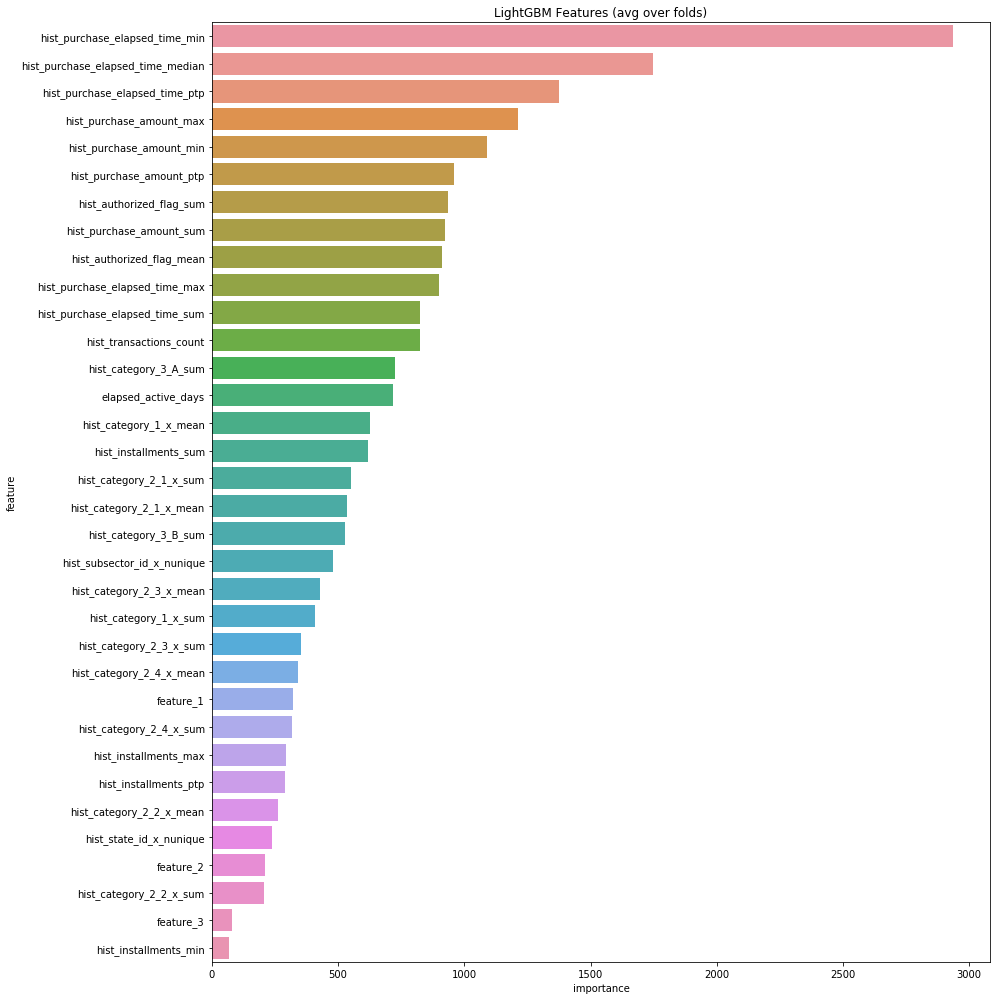

In [93]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [94]:
create_submit_file('submit_2_5.csv')

## Iterative Improvements

In [89]:
# Get top 25 features
top_25_features=ximp.sort_values(by=['importance'],ascending=False).head(25)

In [ ]:
xtrain_25 = xtrain[top_25_features.feature.values]
xtest_25 = xtest[top_25_features.feature.values]

In [ ]:
train_ds = xtrain_25
train_target = ytrain
test_ds = xtest_25

In [ ]:
feature_importance_df = np.zeros((train_ds.shape[1], nfolds))
mvalid = np.zeros(len(train_ds))
mfull = np.zeros(len(test_ds))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_ds.values, train_target.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0,y0 = train_ds.iloc[trn_idx], train_target[trn_idx]
    x1,y1 = train_ds.iloc[val_idx], train_target[val_idx]

    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(test_ds, num_iteration=clf.best_iteration) / folds.n_splits

In [ ]:
# Find feature Importance
ximp = pd.DataFrame()
ximp['feature'] = x_25.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)

display(ximp.sort_values(by=['importance'],ascending=False))

In [ ]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [ ]:
create_submit_file('submit_2_6.csv')

## Next, we will include the outliers in the training dataset and rerun the model again to check whether better performance is obtained.

In [ ]:
train_outliers = train[train['target']<-30]

In [8]:
hist_tran_train_outliers=pd.merge(train_outliers,historical_transactions, on='card_id', how='left')
display(hist_tran_train_outliers.info())

In [16]:
hist_tran_train_outliers_2=transform_train_hist_tran(hist_tran_train_outliers)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,authorized_flag,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,purchase_elapsed_time,category_2_1,category_2_2,category_2_3,category_2_4,category_3_A,category_3_B
0,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1,149,0,1,705,M_ID_f15a843a23,-1,-0.618055,2018-01-06 11:57:23,20,33,26,0,0,0,0,0,1
1,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1,-1,1,2,683,M_ID_7de9fe0811,-4,-0.431381,2017-10-08 02:54:59,-1,34,116,1,0,0,0,0,0
2,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1,304,0,1,690,M_ID_fbd2a9a388,-5,-0.611714,2017-09-30 21:07:14,20,1,124,0,0,0,0,0,1
3,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1,149,0,1,705,M_ID_96fad20d15,-2,-0.405535,2017-12-26 16:50:51,20,33,37,0,0,0,0,0,1
4,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1,149,0,1,842,M_ID_7e872c40f6,-1,-0.623690,2018-01-13 21:31:40,20,37,19,0,0,0,0,0,1


first_active_month         0
card_id                    0
feature_1                  0
feature_2                  0
feature_3                  0
target                     0
elapsed_active_days        0
authorized_flag            0
city_id                    0
category_1                 0
installments               0
merchant_category_id       0
merchant_id              209
month_lag                  0
purchase_amount            0
purchase_date              0
state_id                   0
subsector_id               0
purchase_elapsed_time      0
category_2_1               0
category_2_2               0
category_2_3               0
category_2_4               0
category_3_A               0
category_3_B               0
dtype: int64

In [19]:
hist_tran_train_outliers_merchants=pd.merge(hist_tran_train_outliers_2, merchants, on='merchant_id', how='left')

In [20]:
agg_history_train_outliers = aggregate_history(hist_tran_train_outliers_merchants)

C:\Users\Mishraji\Miniconda3\envs\py3\lib\site-packages\numpy\core\fromnumeric.py:2223: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [21]:
agg_history_train_outliers.to_csv(intermediate_data_path+'agg_history_train_outliers.csv',index=False)
hist_tran_train_outliers.to_csv(intermediate_data_path+'hist_tran_train_outliers.csv',index=False)

In [24]:
agg_history_low_target=pd.read_csv(intermediate_data_path+"agg_history_low_target.csv")
agg_history_med_target=pd.read_csv(intermediate_data_path+"agg_history_med_target.csv")
agg_history_high_target=pd.read_csv(intermediate_data_path+"agg_history_high_target.csv")

agg_history=pd.concat([agg_history_train_outliers+ agg_history_low_target, agg_history_med_target, agg_history_high_target])
# Now, you can run steps after 41

In [27]:
new_mer_tran_outliers=pd.merge(train_outliers,new_merchant_transactions, on='card_id', how='left')

In [28]:
new_mer_tran_outliers_2=transform_train_hist_tran(new_mer_tran_outliers)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,elapsed_active_days,authorized_flag,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,purchase_elapsed_time,category_2_1,category_2_2,category_2_3,category_2_4,category_3_A,category_3_B
0,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1.0,149.0,0.0,1.0,367.0,NaN,1.0,-0.701828,2018-03-10 22:51:58,20.0,16.0,-37.0,0,0,0,0,0,1
1,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1.0,149.0,0.0,1.0,80.0,M_ID_fbaae334f0,2.0,-0.682594,2018-04-23 20:55:01,20.0,37.0,-81.0,0,0,0,0,0,1
2,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1.0,149.0,0.0,1.0,560.0,M_ID_b55158e29e,2.0,-0.701152,2018-04-07 11:26:11,20.0,34.0,-65.0,0,0,0,0,0,1
3,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1.0,149.0,0.0,1.0,130.0,M_ID_b3dc59a9a9,1.0,-0.709342,2018-03-08 08:49:23,20.0,41.0,-35.0,0,0,0,0,0,1
4,2017-09-01,C_ID_8186f3fcc1,3,1,1,-33.219281,153,1.0,288.0,0.0,1.0,80.0,M_ID_2d22260d5e,1.0,-0.695818,2018-03-16 20:37:22,20.0,37.0,-43.0,0,0,0,0,0,1


first_active_month         0
card_id                    0
feature_1                  0
feature_2                  0
feature_3                  0
target                     0
elapsed_active_days        0
authorized_flag          574
city_id                  574
category_1               574
installments             574
merchant_category_id     574
merchant_id              686
month_lag                574
purchase_amount          574
purchase_date            574
state_id                 574
subsector_id             574
purchase_elapsed_time    574
category_2_1               0
category_2_2               0
category_2_3               0
category_2_4               0
category_3_A               0
category_3_B               0
dtype: int64

In [29]:
new_mer_tran_merchants_outliers=pd.merge(new_mer_tran_outliers_2,merchants, on='merchant_id', how='left')

In [30]:
agg_new_merchants_outliers = aggregate_new_merchant(new_mer_tran_merchants_outliers)

In [31]:
agg_new_merchants_outliers.to_csv(intermediate_data_path+'agg_new_merchants_outliers.csv',index=False)

In [35]:
del historical_transactions
del new_merchant_transactions
del new_mer_tran_merchants_outliers
del new_mer_tran_outliers_2
del new_mer_tran_outliers
del hist_tran_train_outliers_merchants
del hist_tran_train_outliers
del hist_tran_train_outliers_2
gc.collect()

512

In [68]:
# Load the aggregate datasets if not available
del agg_history
del agg_new_merchants
del agg_history_test
del agg_new_merchants_test
gc.collect()

agg_history=pd.read_csv(intermediate_data_path+'agg_history.csv')
agg_new_merchants=pd.read_csv(intermediate_data_path+'agg_new_merchants.csv')
agg_history_test=pd.read_csv(intermediate_data_path+'agg_history_test.csv')
agg_new_merchants_test=pd.read_csv(intermediate_data_path+'agg_new_merchants_test.csv')

In [65]:
display(agg_history_train_outliers.head(5))
display(agg_new_merchants_outliers.head(5))

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_001982552a,80,77,0.962500,4,0.050000,69.0,0.862500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,79.0,7,0.0,17.0,0.0,1,81,2,1,21,27,42,8,-179,-8,0,0.372056,-53.628509,-0.367338,-0.739395,5,13,264,14132,151.0,358,94,55.007889,518.205340,54.950419,-0.057471,93.00,1.162500,242.43,3.030375,261.41,3.267625,103.644871,1.295561,604.939457,7.561743,654.780369,8.184755,69.0,16.0
1,C_ID_0029d52418,382,303,0.793194,361,0.945026,382.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,374.0,4,12.0,362.0,0.0,11,420,12,1,16,14,23,12,-1770,-12,0,0.900088,-273.226839,0.154683,-0.745405,2,12,394,60983,142.0,395,1,117.888213,445.692590,117.830742,-0.057471,388.50,1.017016,349.52,0.914974,286.32,0.749529,405.673381,1.061972,375.521796,0.983041,321.790218,0.842383,374.0,365.0
2,C_ID_0046b2b355,26,20,0.769231,0,0.000000,26.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,26.0,0.0,2,0.0,4.0,0.0,0,0,0,0,10,9,14,8,-91,-8,0,0.366947,-16.758648,-0.378458,-0.745405,2,7,232,6437,244.0,369,137,3.380982,11.226585,3.323512,-0.057471,39.39,1.515000,44.08,1.695385,45.38,1.745385,51.700872,1.988495,59.944005,2.305539,61.012478,2.346634,4.0,12.0
3,C_ID_0050fc55c0,19,19,1.000000,3,0.157895,5.0,0.263158,0.0,0.0,14.0,0.736842,0.0,0.0,0.0,17.0,3,0.0,19.0,0.0,1,21,2,1,9,6,10,6,-78,-7,-1,0.267171,-11.858908,-0.446378,-0.713549,3,8,202,3875,226.0,295,93,2.171364,2.259295,2.113893,-0.057471,30.44,1.602105,32.66,1.718947,32.77,1.724737,42.194622,2.220770,48.314924,2.542891,49.010811,2.579516,19.0,9.0
4,C_ID_005799985c,12,11,0.916667,0,0.000000,12.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,12.0,0.0,2,1.0,2.0,0.0,0,0,0,0,5,3,5,10,-90,-13,-3,0.145382,-7.489289,-0.526394,-0.671775,1,5,311,2583,191.0,395,84,0.446171,2.473207,0.388700,-0.057471,18.10,1.508333,24.05,2.004167,31.60,2.633333,23.671070,1.972589,27.922752,2.326896,30.478614,2.539884,3.0,3.0


,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_2_1_x_sum,new_mer_category_2_1_x_mean,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_3_A_sum,new_mer_category_3_B_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_time_ptp,new_mer_purchase_elapsed_time_sum,new_mer_purchase_elapsed_time_median,new_mer_purchase_elapsed_time_max,new_mer_purchase_elapsed_time_min,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_001982552a,10,10.0,1.0,1.0,0.1,10,1.0,0,0.0,0,0.0,0,0.0,0,9,4,1.0,2.0,0.0,1.0,11.0,2.0,1.0,9,10,10,1.0,19.0,1.0,2.0,0.563043,-5.852466,-0.177403,-0.740446,3,7,22.0,538.0,53.0,64.0,42.0,0.56515,0.387039,0.507679,-0.057471,11.24,1.124,11.00,1.10,11.51,1.151,10.958039,1.095804,10.911032,1.091103,10.900522,1.090052,10.0,3.0
1,C_ID_0029d52418,1,1.0,1.0,1.0,1.0,1,1.0,0,0.0,0,0.0,0,0.0,0,1,1,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1,1,1,0.0,1.0,1.0,1.0,0.000000,-0.701828,-0.701828,-0.701828,1,1,0.0,-10.0,-10.0,-10.0,-10.0,0.00000,0.041678,0.041678,0.041678,1.02,1.020,1.04,1.04,1.03,1.030,1.005719,1.005719,1.011846,1.011846,0.994927,0.994927,1.0,0.0
2,C_ID_0046b2b355,1,1.0,1.0,0.0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,0.000000,-0.671775,-0.671775,-0.671775,1,1,0.0,116.0,116.0,116.0,116.0,0.00000,-0.057471,-0.057471,-0.057471,0.90,0.900,1.01,1.01,1.07,1.070,0.902191,0.902191,0.940532,0.940532,0.972027,0.972027,0.0,1.0
3,C_ID_0050fc55c0,1,0.0,NaN,0.0,NaN,1,1.0,0,0.0,0,0.0,0,0.0,1,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0,0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,0.0
4,C_ID_005799985c,1,1.0,1.0,0.0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,0.000000,-0.671775,-0.671775,-0.671775,1,1,0.0,-52.0,-52.0,-52.0,-52.0,0.00000,-0.057471,-0.057471,-0.057471,1.15,1.150,1.18,1.18,1.22,1.220,1.160285,1.160285,1.230187,1.230187,1.331033,1.331033,0.0,1.0


In [71]:
agg_history = pd.concat([agg_history_train_outliers, agg_history])
agg_new_merchants = pd.concat([agg_new_merchants_outliers, agg_new_merchants]) 
display(agg_history.head(5))
display(agg_new_merchants.head(5))
display(agg_history.shape)
display(agg_new_merchants.shape)

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,C_ID_001982552a,80,77,0.962500,4,0.050000,69.0,0.862500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,79.0,7,0.0,17.0,0.0,1,81,2,1,21,27,42,8,-179,-8,0,0.372056,-53.628509,-0.367338,-0.739395,5,13,264,14132,151.0,358,94,55.007889,518.205340,54.950419,-0.057471,93.00,1.162500,242.43,3.030375,261.41,3.267625,103.644871,1.295561,604.939457,7.561743,654.780369,8.184755,69.0,16.0
1,C_ID_0029d52418,382,303,0.793194,361,0.945026,382.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,374.0,4,12.0,362.0,0.0,11,420,12,1,16,14,23,12,-1770,-12,0,0.900088,-273.226839,0.154683,-0.745405,2,12,394,60983,142.0,395,1,117.888213,445.692590,117.830742,-0.057471,388.50,1.017016,349.52,0.914974,286.32,0.749529,405.673381,1.061972,375.521796,0.983041,321.790218,0.842383,374.0,365.0
2,C_ID_0046b2b355,26,20,0.769231,0,0.000000,26.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,26.0,0.0,2,0.0,4.0,0.0,0,0,0,0,10,9,14,8,-91,-8,0,0.366947,-16.758648,-0.378458,-0.745405,2,7,232,6437,244.0,369,137,3.380982,11.226585,3.323512,-0.057471,39.39,1.515000,44.08,1.695385,45.38,1.745385,51.700872,1.988495,59.944005,2.305539,61.012478,2.346634,4.0,12.0
3,C_ID_0050fc55c0,19,19,1.000000,3,0.157895,5.0,0.263158,0.0,0.0,14.0,0.736842,0.0,0.0,0.0,17.0,3,0.0,19.0,0.0,1,21,2,1,9,6,10,6,-78,-7,-1,0.267171,-11.858908,-0.446378,-0.713549,3,8,202,3875,226.0,295,93,2.171364,2.259295,2.113893,-0.057471,30.44,1.602105,32.66,1.718947,32.77,1.724737,42.194622,2.220770,48.314924,2.542891,49.010811,2.579516,19.0,9.0
4,C_ID_005799985c,12,11,0.916667,0,0.000000,12.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.0,12.0,0.0,2,1.0,2.0,0.0,0,0,0,0,5,3,5,10,-90,-13,-3,0.145382,-7.489289,-0.526394,-0.671775,1,5,311,2583,191.0,395,84,0.446171,2.473207,0.388700,-0.057471,18.10,1.508333,24.05,2.004167,31.60,2.633333,23.671070,1.972589,27.922752,2.326896,30.478614,2.539884,3.0,3.0


,card_id,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_2_1_x_sum,new_mer_category_2_1_x_mean,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_3_A_sum,new_mer_category_3_B_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_time_ptp,new_mer_purchase_elapsed_time_sum,new_mer_purchase_elapsed_time_median,new_mer_purchase_elapsed_time_max,new_mer_purchase_elapsed_time_min,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_category_4_sum,new_mer_numerical_1_low_sum
0,C_ID_001982552a,10,10.0,1.0,1.0,0.1,10,1.0,0,0.0,0,0.0,0,0.0,0,9,4,1.0,2.0,0.0,1.0,11.0,2.0,1.0,9,10,10,1.0,19.0,1.0,2.0,0.563043,-5.852466,-0.177403,-0.740446,3,7,22.0,538.0,53.0,64.0,42.0,0.56515,0.387039,0.507679,-0.057471,11.24,1.124,11.00,1.10,11.51,1.151,10.958039,1.095804,10.911032,1.091103,10.900522,1.090052,10.0,3.0
1,C_ID_0029d52418,1,1.0,1.0,1.0,1.0,1,1.0,0,0.0,0,0.0,0,0.0,0,1,1,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1,1,1,0.0,1.0,1.0,1.0,0.000000,-0.701828,-0.701828,-0.701828,1,1,0.0,-10.0,-10.0,-10.0,-10.0,0.00000,0.041678,0.041678,0.041678,1.02,1.020,1.04,1.04,1.03,1.030,1.005719,1.005719,1.011846,1.011846,0.994927,0.994927,1.0,0.0
2,C_ID_0046b2b355,1,1.0,1.0,0.0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,0.000000,-0.671775,-0.671775,-0.671775,1,1,0.0,116.0,116.0,116.0,116.0,0.00000,-0.057471,-0.057471,-0.057471,0.90,0.900,1.01,1.01,1.07,1.070,0.902191,0.902191,0.940532,0.940532,0.972027,0.972027,0.0,1.0
3,C_ID_0050fc55c0,1,0.0,NaN,0.0,NaN,1,1.0,0,0.0,0,0.0,0,0.0,1,0,0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0,0,0,NaN,0.0,NaN,NaN,NaN,0.000000,NaN,NaN,0,0,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.0,0.0
4,C_ID_005799985c,1,1.0,1.0,0.0,0.0,1,1.0,0,0.0,0,0.0,0,0.0,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,0.0,1.0,1.0,1.0,0.000000,-0.671775,-0.671775,-0.671775,1,1,0.0,-52.0,-52.0,-52.0,-52.0,0.00000,-0.057471,-0.057471,-0.057471,1.15,1.150,1.18,1.18,1.22,1.220,1.160285,1.160285,1.230187,1.230187,1.331033,1.331033,0.0,1.0


(201917, 60)

(201917, 60)

In [73]:
ytrain = train['target']
del train['target']

print(train.shape)
print(test.shape)

KeyError: 'target'

In [74]:
print(train.shape)
print(test.shape)

xtrain = pd.merge(train, agg_new_merchants, on='card_id', how='left')
xtest = pd.merge(test, agg_new_merchants_test, on='card_id', how='left')

print(xtrain.shape)
print(xtest.shape)

xtrain = pd.merge(xtrain, agg_history, on='card_id', how='left')
xtest = pd.merge(xtest, agg_history_test, on='card_id', how='left')

print(xtrain.shape)
print(xtest.shape)
gc.collect()

(201917, 6)
(123623, 6)
(201917, 65)
(123623, 65)
(201917, 124)
(123623, 124)


45

In [75]:
#Deriving the final features for modeling
xtrain.drop('first_active_month', axis = 1, inplace = True)
xtest.drop('first_active_month', axis = 1, inplace = True)

# Combine the train and test datasets to derive the one hot encoding from the categorical features.
train_test=pd.concat([xtrain, xtest])
categorical_features = ['feature_1', 'feature_2', 'feature_3']
len_train=xtrain.shape[0]
le = LabelEncoder()
for col in categorical_features:
    train_test[col] = le.fit_transform(train_test[col])
xtrain = train_test[:len_train]
xtest = train_test[len_train:]
display(xtrain.shape)
display(xtest.shape)

(201917, 123)

(123623, 123)

In [76]:
id_train = xtrain['card_id'].copy(); 
xtrain.drop('card_id', axis = 1, inplace = True)
id_test = xtest['card_id'].copy(); 
xtest.drop('card_id', axis = 1, inplace = True)

In [77]:
display(xtrain.head(5))
display(xtest.head(5))

,feature_1,feature_2,feature_3,elapsed_active_days,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_2_1_x_sum,new_mer_category_2_1_x_mean,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_3_A_sum,new_mer_category_3_B_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_time_ptp,new_mer_purchase_elapsed_time_sum,new_mer_purchase_elapsed_time_median,new_mer_purchase_elapsed_time_max,new_mer_purchase_elapsed_time_min,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_category_4_sum,new_mer_numerical_1_low_sum,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,4,1,1,245.0,23,23.0,1.0,0.0,0.000000,23,1.000000,0,0.0,0,0.000000,0,0.000000,23,0,3,19.0,4.0,0.0,0.0,0.0,0.0,0.0,14,17,23,1.0,34.0,1.0,2.0,0.428256,-13.244202,-0.296112,-0.724368,1,10,55.0,-1340.0,-58.0,-32.0,-87.0,183.792582,633.757544,183.735111,-0.057471,25.31,1.100435,25.02,1.087826,28.15,1.223913,25.009007,1.087348,24.618138,1.070354,26.103974,1.134955,19.0,6.0,265,252,0.950943,0,0.000000,262.0,0.988679,0.0,0.0,0.0,0.0,0.0,0.000000,261.0,4.0,7,223.0,25.0,0.0,1,4,1,0,41,73,94,8,-1025,-8,0,2.997789,-169.408819,2.258395,-0.739395,3,21,243,27657,103.0,219,-24,172.777123,4054.082784,172.719653,-0.057471,326.47,1.260502,1878.67,7.253552,2146.41,8.287297,402.586644,1.554389,5458.811530,21.076492,6016.990200,23.231622,247.0,58.0
1,3,0,0,396.0,6,6.0,1.0,0.0,0.000000,6,1.000000,0,0.0,0,0.000000,0,0.000000,0,6,1,6.0,0.0,0.0,0.0,6.0,1.0,

,feature_1,feature_2,feature_3,elapsed_active_days,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_2_1_x_sum,new_mer_category_2_1_x_mean,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_3_A_sum,new_mer_category_3_B_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_time_ptp,new_mer_purchase_elapsed_time_sum,new_mer_purchase_elapsed_time_median,new_mer_purchase_elapsed_time_max,new_mer_purchase_elapsed_time_min,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_category_4_sum,new_mer_numerical_1_low_sum,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,2,2,1,306.0,3,3.0,1.0,0.0,0.0,3,1.0,0,0.0,0,0.000000,0,0.000000,0,2,3,0.0,1.0,0.0,2.0,5.0,3.0,1.0,3,3,3,0.0,6.0,2.0,2.0,0.338848,-1.777156,-0.383266,-0.722114,1,3,25.0,-44.0,-15.0,-2.0,-27.0,0.019830,-0.122837,-0.027726,-0.047556,3.29,1.096667,3.54,1.180000,3.70,1.233333,3.368813,1.122938,3.602459,1.200819,3.822576,1.274192,0.0,0.0,71,47,0.661972,23,0.323944,71.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,49.0,7,0.0,30.0,0.0,11,144,12,1,16,13,24,8,-260,-8,0,0.979578,-42.859203,0.235676,-0.743902,3,12,269,11282,158.0,303,34,2.677024,5.705594,2.619554,-0.057471,100.73,1.418732,110.57,1.557324,105.34,1.483662,109.807612,1.546586,120.123323,1.691878,115.549787,1.627462,35.0,35.0
1,1,2,0,396.0,10,10.0,1.0,3.0,0.3,3,0.3,0,0.0,0,0.000000,7,0.700000,0,9,2,0.0,10.0,0.0,2.0,12.0,3.0,1.0,8,8,9,1.0,14.0,1.0,2.0,0.234414,-6.556518,-0.50648

In [78]:
#setting parameters for lightgbm
param = {}
param['learning_rate']=0.01
param['boosting_type']='gbdt'
param['objective']='regression'
param['metric']='l2_root'
param['sub_feature'] = 0.5
param['num_leaves'] = 30
param['min_data'] = 50
param['max_depth'] = 7

In [79]:
nfolds = 10
folds = KFold(n_splits= nfolds, shuffle=True, random_state=15)

In [80]:
train_ds = xtrain
train_target = ytrain
test_ds = xtest

In [81]:
display(train_ds.head(5))
display(train_target.head(5))
display(test_ds.head(5))

,feature_1,feature_2,feature_3,elapsed_active_days,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_2_1_x_sum,new_mer_category_2_1_x_mean,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_3_A_sum,new_mer_category_3_B_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_time_ptp,new_mer_purchase_elapsed_time_sum,new_mer_purchase_elapsed_time_median,new_mer_purchase_elapsed_time_max,new_mer_purchase_elapsed_time_min,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_category_4_sum,new_mer_numerical_1_low_sum,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,4,1,1,245.0,23,23.0,1.0,0.0,0.000000,23,1.000000,0,0.0,0,0.000000,0,0.000000,23,0,3,19.0,4.0,0.0,0.0,0.0,0.0,0.0,14,17,23,1.0,34.0,1.0,2.0,0.428256,-13.244202,-0.296112,-0.724368,1,10,55.0,-1340.0,-58.0,-32.0,-87.0,183.792582,633.757544,183.735111,-0.057471,25.31,1.100435,25.02,1.087826,28.15,1.223913,25.009007,1.087348,24.618138,1.070354,26.103974,1.134955,19.0,6.0,265,252,0.950943,0,0.000000,262.0,0.988679,0.0,0.0,0.0,0.0,0.0,0.000000,261.0,4.0,7,223.0,25.0,0.0,1,4,1,0,41,73,94,8,-1025,-8,0,2.997789,-169.408819,2.258395,-0.739395,3,21,243,27657,103.0,219,-24,172.777123,4054.082784,172.719653,-0.057471,326.47,1.260502,1878.67,7.253552,2146.41,8.287297,402.586644,1.554389,5458.811530,21.076492,6016.990200,23.231622,247.0,58.0
1,3,0,0,396.0,6,6.0,1.0,0.0,0.000000,6,1.000000,0,0.0,0,0.000000,0,0.000000,0,6,1,6.0,0.0,0.0,0.0,6.0,1.0,

0   -0.820283
1    0.392913
2    0.688056
3    0.142495
4   -0.159749
Name: target, dtype: float64

,feature_1,feature_2,feature_3,elapsed_active_days,new_mer_transactions_count,new_mer_authorized_flag_sum,new_mer_authorized_flag_mean,new_mer_category_1_x_sum,new_mer_category_1_x_mean,new_mer_category_2_1_x_sum,new_mer_category_2_1_x_mean,new_mer_category_2_2_x_sum,new_mer_category_2_2_x_mean,new_mer_category_2_3_x_sum,new_mer_category_2_3_x_mean,new_mer_category_2_4_x_sum,new_mer_category_2_4_x_mean,new_mer_category_3_A_sum,new_mer_category_3_B_sum,new_mer_city_id_x_nunique,new_mer_city_id_69_sum,new_mer_city_id_neg_1_sum,new_mer_city_id_333_sum,new_mer_installments_ptp,new_mer_installments_sum,new_mer_installments_max,new_mer_installments_min,new_mer_merchant_category_id_x_nunique,new_mer_merchant_group_id_nunique,new_mer_merchant_id_nunique,new_mer_month_lag_ptp,new_mer_month_lag_sum,new_mer_month_lag_min,new_mer_month_lag_max,new_mer_purchase_amount_ptp,new_mer_purchase_amount_sum,new_mer_purchase_amount_max,new_mer_purchase_amount_min,new_mer_state_id_x_nunique,new_mer_subsector_id_x_nunique,new_mer_purchase_elapsed_time_ptp,new_mer_purchase_elapsed_time_sum,new_mer_purchase_elapsed_time_median,new_mer_purchase_elapsed_time_max,new_mer_purchase_elapsed_time_min,new_mer_numerical_1_ptp,new_mer_numerical_1_sum,new_mer_numerical_1_max,new_mer_numerical_1_min,new_mer_avg_sales_lag3_sum,new_mer_avg_sales_lag3_mean,new_mer_avg_sales_lag6_sum,new_mer_avg_sales_lag6_mean,new_mer_avg_sales_lag12_sum,new_mer_avg_sales_lag12_mean,new_mer_avg_purchases_lag3_sum,new_mer_avg_purchases_lag3_mean,new_mer_avg_purchases_lag6_sum,new_mer_avg_purchases_lag6_mean,new_mer_avg_purchases_lag12_sum,new_mer_avg_purchases_lag12_mean,new_mer_category_4_sum,new_mer_numerical_1_low_sum,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_x_sum,hist_category_1_x_mean,hist_category_2_1_x_sum,hist_category_2_1_x_mean,hist_category_2_2_x_sum,hist_category_2_2_x_mean,hist_category_2_3_x_sum,hist_category_2_3_x_mean,hist_category_2_4_x_sum,hist_category_2_4_x_mean,hist_category_3_A_sum,hist_category_3_B_sum,hist_city_id_x_nunique,hist_city_id_69_sum,hist_city_id_neg_1_sum,hist_city_id_333_sum,hist_installments_ptp,hist_installments_sum,hist_installments_max,hist_installments_min,hist_merchant_category_id_x_nunique,hist_merchant_group_id_nunique,hist_merchant_id_nunique,hist_month_lag_ptp,hist_month_lag_sum,hist_month_lag_min,hist_month_lag_max,hist_purchase_amount_ptp,hist_purchase_amount_sum,hist_purchase_amount_max,hist_purchase_amount_min,hist_state_id_x_nunique,hist_subsector_id_x_nunique,hist_purchase_elapsed_time_ptp,hist_purchase_elapsed_time_sum,hist_purchase_elapsed_time_median,hist_purchase_elapsed_time_max,hist_purchase_elapsed_time_min,hist_numerical_1_ptp,hist_numerical_1_sum,hist_numerical_1_max,hist_numerical_1_min,hist_avg_sales_lag3_sum,hist_avg_sales_lag3_mean,hist_avg_sales_lag6_sum,hist_avg_sales_lag6_mean,hist_avg_sales_lag12_sum,hist_avg_sales_lag12_mean,hist_avg_purchases_lag3_sum,hist_avg_purchases_lag3_mean,hist_avg_purchases_lag6_sum,hist_avg_purchases_lag6_mean,hist_avg_purchases_lag12_sum,hist_avg_purchases_lag12_mean,hist_category_4_sum,hist_numerical_1_low_sum
0,2,2,1,306.0,3,3.0,1.0,0.0,0.0,3,1.0,0,0.0,0,0.000000,0,0.000000,0,2,3,0.0,1.0,0.0,2.0,5.0,3.0,1.0,3,3,3,0.0,6.0,2.0,2.0,0.338848,-1.777156,-0.383266,-0.722114,1,3,25.0,-44.0,-15.0,-2.0,-27.0,0.019830,-0.122837,-0.027726,-0.047556,3.29,1.096667,3.54,1.180000,3.70,1.233333,3.368813,1.122938,3.602459,1.200819,3.822576,1.274192,0.0,0.0,71,47,0.661972,23,0.323944,71.0,1.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,49.0,7,0.0,30.0,0.0,11,144,12,1,16,13,24,8,-260,-8,0,0.979578,-42.859203,0.235676,-0.743902,3,12,269,11282,158.0,303,34,2.677024,5.705594,2.619554,-0.057471,100.73,1.418732,110.57,1.557324,105.34,1.483662,109.807612,1.546586,120.123323,1.691878,115.549787,1.627462,35.0,35.0
1,1,2,0,396.0,10,10.0,1.0,3.0,0.3,3,0.3,0,0.0,0,0.000000,7,0.700000,0,9,2,0.0,10.0,0.0,2.0,12.0,3.0,1.0,8,8,9,1.0,14.0,1.0,2.0,0.234414,-6.556518,-0.50648

In [82]:
feature_importance_df = np.zeros((train_ds.shape[1], nfolds))
mvalid = np.zeros(len(train_ds))
mfull = np.zeros(len(test_ds))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_ds.values, train_target.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0,y0 = train_ds.iloc[trn_idx], train_target[trn_idx]
    x1,y1 = train_ds.iloc[val_idx], train_target[val_idx]

    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(test_ds, num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.57522	valid_1's rmse: 3.72526
[1000]	training's rmse: 3.51696	valid_1's rmse: 3.71363
[1500]	training's rmse: 3.47357	valid_1's rmse: 3.71117
Early stopping, best iteration is:
[1537]	training's rmse: 3.4707	valid_1's rmse: 3.71093
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.57924	valid_1's rmse: 3.66668
[1000]	training's rmse: 3.5191	valid_1's rmse: 3.66421
Early stopping, best iteration is:
[884]	training's rmse: 3.53108	valid_1's rmse: 3.66369
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.585	valid_1's rmse: 3.59835
[1000]	training's rmse: 3.52339	valid_1's rmse: 3.58977
[1500]	training's rmse: 3.47808	valid_1's rmse: 3.58815
Early stopping, best iteration is:
[1645]	training's rmse: 3.46636	valid_1's rmse: 3.58778
----
fold n°3
Training until validation scores don't imp

,feature,importance
103,hist_purchase_elapsed_time_min,1765.8
44,new_mer_purchase_elapsed_time_min,1731.0
36,new_mer_purchase_amount_max,1525.5
42,new_mer_purchase_elapsed_time_median,1107.2
43,new_mer_purchase_elapsed_time_max,1083.2
99,hist_purchase_elapsed_time_ptp,1062.0
66,hist_category_1_x_sum,1027.5
65,hist_authorized_flag_mean,965.1
40,new_mer_purchase_elapsed_time_ptp,940.9
101,hist_purchase_elapsed_time_median,893.5


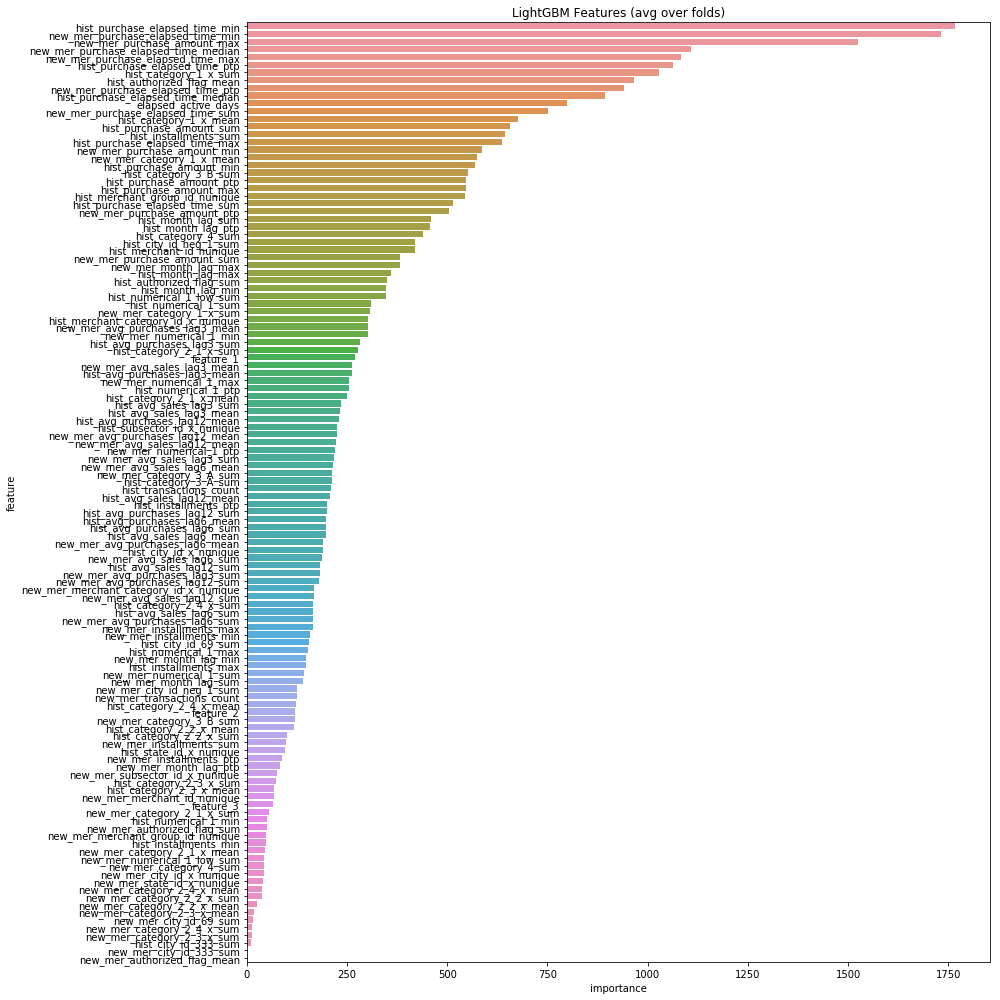

In [83]:
# Find feature Importance
ximp = pd.DataFrame()
ximp['feature'] = train_ds.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)
display(ximp.sort_values(by=['importance'],ascending=False))

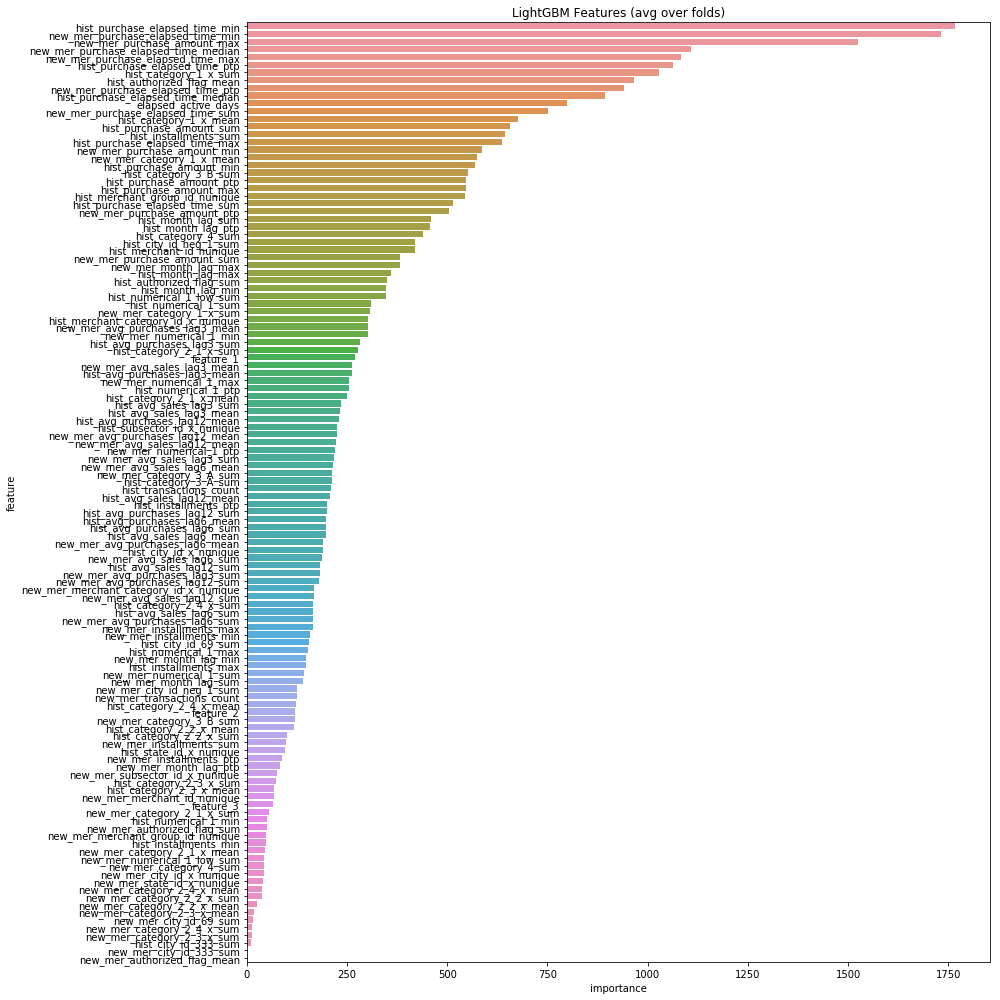

In [84]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [86]:
create_submit_file('submit_2_7.csv')

In [88]:
ximp.to_csv(intermediate_data_path+'ximp_2_7.csv',index=False)

## Iterative Improvements
We choose only the top 30 features.

In [89]:
top_30_features=ximp.sort_values(by=['importance'],ascending=False).head(30)
xtrain_30 = xtrain[top_30_features.feature.values]
xtest_30 = xtest[top_30_features.feature.values]

In [91]:
train_ds = xtrain_30
train_target = ytrain
test_ds = xtest_30

In [92]:
feature_importance_df = np.zeros((train_ds.shape[1], nfolds))
mvalid = np.zeros(len(train_ds))
mfull = np.zeros(len(test_ds))

#start = time.time()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_ds.values, train_target.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0,y0 = train_ds.iloc[trn_idx], train_target[trn_idx]
    x1,y1 = train_ds.iloc[val_idx], train_target[val_idx]

    trn_data = lgb.Dataset(x0, label= y0); val_data = lgb.Dataset(x1, label= y1)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 150)
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(test_ds, num_iteration=clf.best_iteration) / folds.n_splits

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.59378	valid_1's rmse: 3.72955
[1000]	training's rmse: 3.53815	valid_1's rmse: 3.71758
[1500]	training's rmse: 3.49648	valid_1's rmse: 3.71427
Early stopping, best iteration is:
[1716]	training's rmse: 3.48012	valid_1's rmse: 3.71358
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.60019	valid_1's rmse: 3.67591
[1000]	training's rmse: 3.54556	valid_1's rmse: 3.67258
Early stopping, best iteration is:
[1068]	training's rmse: 3.5396	valid_1's rmse: 3.67231
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.60442	valid_1's rmse: 3.60917
[1000]	training's rmse: 3.55107	valid_1's rmse: 3.59977
[1500]	training's rmse: 3.51012	valid_1's rmse: 3.59723
[2000]	training's rmse: 3.47167	valid_1's rmse: 3.59622
Early stopping, best iteration is:
[2081]	training's rmse: 3.46598	valid_1's rmse: 3.59

In [96]:
# Find feature Importance
ximp = pd.DataFrame()
ximp['feature'] = train_ds.columns
ximp['importance'] = feature_importance_df.mean(axis = 1)

display(ximp.sort_values(by=['importance'],ascending=False))

,feature,importance
0,hist_purchase_elapsed_time_min,2921.6
1,new_mer_purchase_elapsed_time_min,2739.2
2,new_mer_purchase_amount_max,2298.9
11,new_mer_purchase_elapsed_time_sum,1911.9
4,new_mer_purchase_elapsed_time_max,1852.8
5,hist_purchase_elapsed_time_ptp,1825.1
6,hist_category_1_x_sum,1814.1
8,new_mer_purchase_elapsed_time_ptp,1792.8
14,hist_installments_sum,1767.2
9,hist_purchase_elapsed_time_median,1680.0


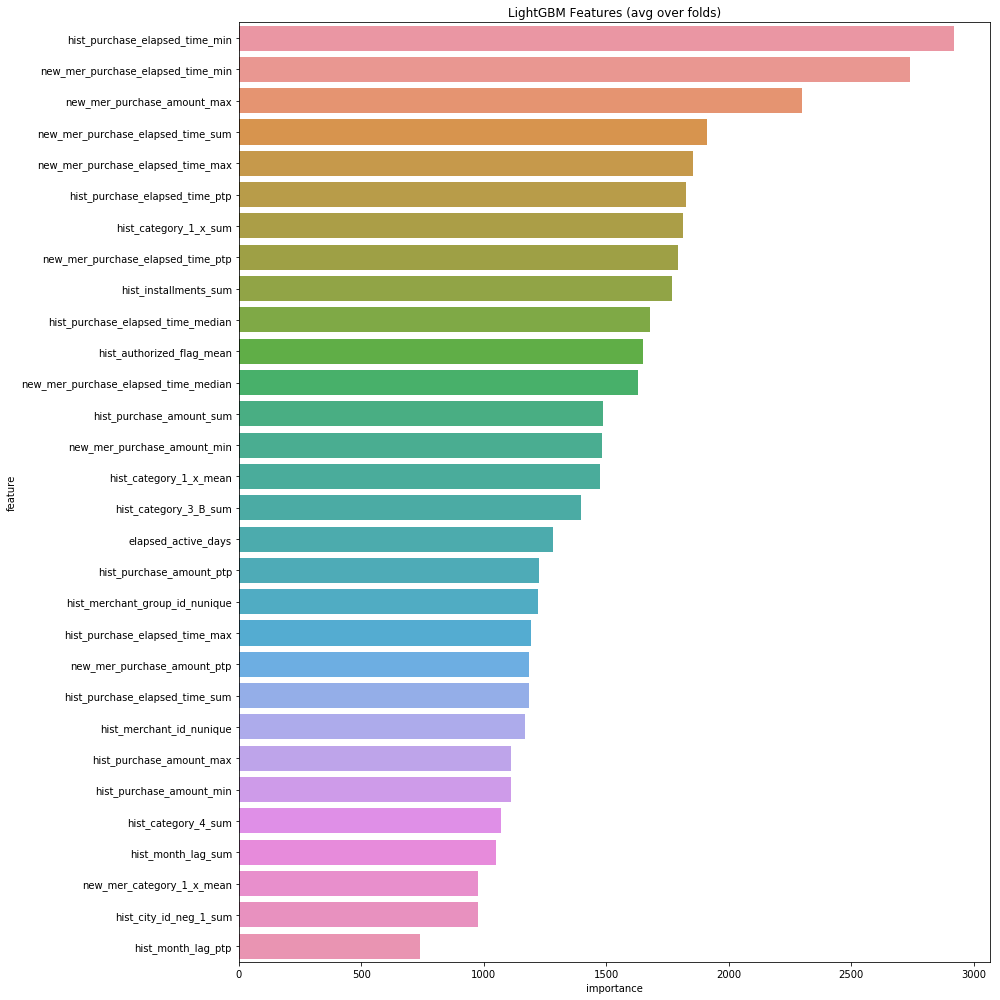

In [98]:
plt.figure(figsize=(14,14))
sns.barplot(x="importance",
            y="feature",
            data=ximp.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [99]:
create_submit_file('submit_2_8.csv')


In [100]:
ximp.to_csv(intermediate_data_path+'ximp_2_8.csv',index=False)

# THE END